Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END clf__et__max_depth=15, clf__et__min_samples_leaf=8, clf__et__n_estimators=220, clf__mlp__activation=relu, clf__mlp__alpha=0.00021751953118777652, clf__mlp__hidden_layer_sizes=(64, 32), clf__mlp__learning_rate_init=0.0008288916866885145, clf__rf__max_depth=20, clf__rf__min_samples_leaf=4, clf__rf__n_estimators=330, clf__xgb__colsample_bytree=0.5102922471479012, clf__xgb__gamma=4.8495492608099715, clf__xgb__learning_rate=0.11536162338241392, clf__xgb__max_depth=8, clf__xgb__n_estimators=585, clf__xgb__reg_alpha=0.18182496720710062, clf__xgb__reg_lambda=0.18340450985343382, clf__xgb__subsample=0.6521211214797689; total time=   2.5s
[CV] END clf__et__max_depth=15, clf__et__min_samples_leaf=8, clf__et__n_estimators=220, clf__mlp__activation=relu, clf__mlp__alpha=0.00021751953118777652, clf__mlp__hidden_layer_sizes=(64, 32), clf__mlp__learning_rate_init=0.0008288916866885145, clf__rf__max_depth=20, clf__rf__min_samples_

/Users/morgancooper/data-science/MSDSResearchProjects/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf__et__max_depth=5, clf__et__min_samples_leaf=3, clf__et__n_estimators=564, clf__mlp__activation=relu, clf__mlp__alpha=3.9941424203878475e-05, clf__mlp__hidden_layer_sizes=(64,), clf__mlp__learning_rate_init=0.00013150526408084372, clf__rf__max_depth=20, clf__rf__min_samples_leaf=1, clf__rf__n_estimators=536, clf__xgb__colsample_bytree=0.9234844271035303, clf__xgb__gamma=4.4654510259770746, clf__xgb__learning_rate=0.0014279566808151776, clf__xgb__max_depth=8, clf__xgb__n_estimators=522, clf__xgb__reg_alpha=0.4483190553694222, clf__xgb__reg_lambda=0.5104324890042322, clf__xgb__subsample=0.8132962555466051; total time=  20.9s
[CV] END clf__et__max_depth=5, clf__et__min_samples_leaf=6, clf__et__n_estimators=548, clf__mlp__activation=tanh, clf__mlp__alpha=0.0014727223343408056, clf__mlp__hidden_layer_sizes=(128,), clf__mlp__learning_rate_init=0.00018572495372661373, clf__rf__max_depth=25, clf__rf__min_samples_leaf=5, clf__rf__n_estimators=403, clf__xgb__colsample_bytree=0.902218

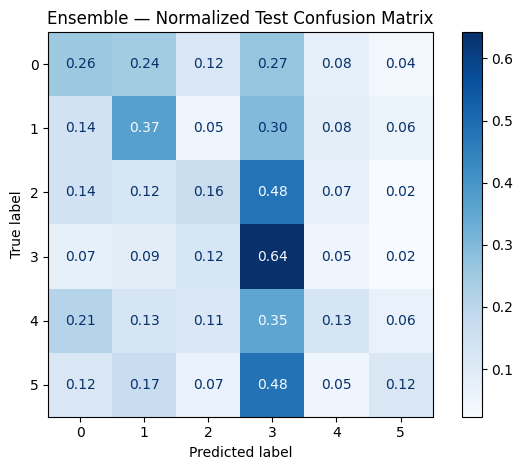

Test Set AUC (OvR): 0.6503

== Confidence Decile Table ==
      Top %  N Samples  Correct Predictions  Accuracy in Decile  \
0   Top 10%         49                   19               0.388   
1   Top 20%         98                   34               0.347   
2   Top 30%        148                   46               0.311   
3   Top 40%        197                   57               0.289   
4   Top 50%        247                   76               0.308   
5   Top 60%        296                   91               0.307   
6   Top 70%        345                  105               0.304   
7   Top 80%        395                  117               0.296   
8   Top 90%        444                  131               0.295   
9  Top 100%        494                  139               0.281   

   Avg Confidence  
0           0.719  
1           0.688  
2           0.660  
3           0.633  
4           0.608  
5           0.583  
6           0.559  
7           0.536  
8           0.514  
9   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_auc_score
)
from scipy.stats import randint, uniform, loguniform

# -----------------------------
# 1. Load and Prepare Data
# -----------------------------
train_df = pd.read_csv("../data/generated_data/train.csv")
test_df = pd.read_csv("../data/generated_data/test.csv")

drop_cols = ["date"]
train_df = train_df.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")
test_df = test_df.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")

train_df['regime_today'] = train_df['regime']
test_df['regime_today'] = test_df['regime']

train_df['regime_t+3'] = train_df['regime'].shift(-3)
test_df['regime_t+3'] = test_df['regime'].shift(-3)

train_df = train_df.drop(columns=['regime']).dropna(subset=['regime_t+3'])
test_df = test_df.drop(columns=['regime']).dropna(subset=['regime_t+3'])

X_train = train_df.drop(columns=['regime_t+3'])
y_train = train_df['regime_t+3'].astype(int) - 1
X_test = test_df.drop(columns=['regime_t+3'])
y_test = test_df['regime_t+3'].astype(int) - 1

# -----------------------------
# 2. Define Base Models
# -----------------------------
xgb = XGBClassifier()
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
mlp = MLPClassifier(max_iter=10000)

# -----------------------------
# 3. Ensemble Voting Classifier
# -----------------------------
voting_clf = VotingClassifier(
    estimators=[
        ("xgb", xgb),
        ("rf", rf),
        ("et", et),
        ("mlp", mlp),
    ],
    voting="soft"
)

pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("clf", voting_clf)
])

# -----------------------------
# 4. Search Space (Large)
# -----------------------------
param_distributions = {
    # XGB
    "clf__xgb__n_estimators": randint(200, 800),
    "clf__xgb__max_depth": randint(3, 12),
    "clf__xgb__learning_rate": loguniform(1e-3, 0.3),
    "clf__xgb__subsample": uniform(0.5, 0.5),
    "clf__xgb__colsample_bytree": uniform(0.5, 0.5),
    "clf__xgb__gamma": uniform(0, 5),
    "clf__xgb__reg_alpha": uniform(0, 1),
    "clf__xgb__reg_lambda": uniform(0, 1),

    # Random Forest
    "clf__rf__n_estimators": randint(200, 800),
    "clf__rf__max_depth": [None] + list(range(5, 30, 5)),
    "clf__rf__min_samples_leaf": randint(1, 10),

    # Extra Trees
    "clf__et__n_estimators": randint(200, 800),
    "clf__et__max_depth": [None] + list(range(5, 30, 5)),
    "clf__et__min_samples_leaf": randint(1, 10),

    # MLP
    "clf__mlp__hidden_layer_sizes": [(64,), (128,), (64, 32), (128, 64), (256, 128)],
    "clf__mlp__activation": ["relu", "tanh"],
    "clf__mlp__alpha": loguniform(1e-5, 1e-2),
    "clf__mlp__learning_rate_init": loguniform(1e-4, 1e-2),
}

# -----------------------------
# 5. RandomizedSearchCV
# -----------------------------
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=200,  # large search
    scoring="roc_auc_ovr",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train)

print("\n== Best Ensemble Params ==")
print(search.best_params_)
print(f"Best CV AUC (OvR): {search.best_score_:.4f}")

best_model = search.best_estimator_

# -----------------------------
# 6. Weight Grid Search
# -----------------------------
weight_grid = [
    (1,1,1,1),
    (2,1,1,1),
    (1,2,1,1),
    (1,1,2,1),
    (1,1,1,2),
    (2,2,1,1),
    (3,1,1,1),
    (1,3,1,1),
    (1,1,3,1),
    (1,1,1,3),
    (4,1,1,1),
    (1,4,1,1),
    (1,1,4,1),
    (1,1,1,4),
]

best_auc, best_weights = -np.inf, None
for w in weight_grid:
    weighted_clf = VotingClassifier(
        estimators=[
            ("xgb", best_model.named_steps["clf"].named_estimators_["xgb"]),
            ("rf", best_model.named_steps["clf"].named_estimators_["rf"]),
            ("et", best_model.named_steps["clf"].named_estimators_["et"]),
            ("mlp", best_model.named_steps["clf"].named_estimators_["mlp"]),
        ],
        voting="soft",
        weights=w
    )
    weighted_clf.fit(RobustScaler().fit_transform(X_train), y_train)
    y_val_proba = weighted_clf.predict_proba(RobustScaler().fit_transform(X_test))
    auc = roc_auc_score(y_test, y_val_proba, multi_class="ovr")
    if auc > best_auc:
        best_auc, best_weights = auc, w

print("\n== Best Weights ==")
print(f"Weights: {best_weights}, Test AUC: {best_auc:.4f}")

final_model = weighted_clf

# -----------------------------
# 7. Evaluate on Test Set
# -----------------------------
y_pred_test = final_model.predict(RobustScaler().fit_transform(X_test))
y_test_proba = final_model.predict_proba(RobustScaler().fit_transform(X_test))

print("\n== Ensemble — TEST Accuracy Report ==")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred_test, digits=4))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_test,
    cmap="Blues",
    normalize="true",          # ✅ normalize confusion matrix
    values_format=".2f"        # ✅ two decimal places for proportions
)
plt.title("Ensemble — Normalized Test Confusion Matrix")
plt.tight_layout()
plt.show()

auc_score = roc_auc_score(y_test, y_test_proba, multi_class="ovr")
print(f"Test Set AUC (OvR): {auc_score:.4f}")


# -----------------------------
# 8. Confidence-Based Decile Analysis
# -----------------------------
confidences = y_test_proba.max(axis=1)
y_pred = np.argmax(y_test_proba, axis=1)

eval_df = pd.DataFrame({
    "true": y_test + 1,
    "pred": y_pred + 1,
    "conf": confidences
})
eval_df["correct"] = (eval_df["true"] == eval_df["pred"]).astype(int)
eval_df = eval_df.sort_values("conf", ascending=False).reset_index(drop=True)

decile_results = []
n = len(eval_df)
for d in range(10, 110, 10):
    cutoff = int((d / 100) * n)
    subset = eval_df.iloc[:cutoff]
    n_samples = len(subset)
    n_correct = subset["correct"].sum()
    accuracy = n_correct / n_samples if n_samples > 0 else 0
    avg_conf = subset["conf"].mean() if n_samples > 0 else 0
    decile_results.append({
        "Top %": f"Top {d}%",
        "N Samples": n_samples,
        "Correct Predictions": n_correct,
        "Accuracy in Decile": round(accuracy, 3),
        "Avg Confidence": round(avg_conf, 3)
    })

decile_df = pd.DataFrame(decile_results)
print("\n== Confidence Decile Table ==")
print(decile_df)
